In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt

# Approach 1
1. Calculate the overlap of contour boxes of door with the bounding box of golf stick
2. Take the box with maximum overlap with golf stick box and calculate the angle of the left edge of the box with the vertical edge of the image 

### Golf stick bbox

In [2]:
# bbox of golf stick 
top_left_x = 213  # X coordinate of the top left corner
top_left_y = 628  # Y coordinate of the top left corner
crop_width = 208  # Width of the crop region
crop_height = 399  # Height of the crop region

### Contour bboxes

In [3]:
# make sure the contour bboxes are calculated on full scale image 
sam_mask = np.load('door_mask.npy')
print(sam_mask.shape)

boolean_mask = sam_mask[0]
boolean_mask.shape

(3, 1280, 720)


(1280, 720)

In [4]:
# Convert boolean mask to an 8-bit unsigned integer mask
int_mask = (boolean_mask * 255).astype(np.uint8)

# Convert the mask to a BGR image
bgr_mask = cv2.merge([int_mask, int_mask, int_mask])

# Convert the mask to grayscale
imgray = cv2.cvtColor(bgr_mask, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale image
ret, thresh = cv2.threshold(imgray, 127, 255, 0)

In [5]:
# Step 1: Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ensure there are contours found
if len(contours) == 0:
    raise ValueError("No contours found in the mask.")

In [6]:
len(contours)

12

In [10]:
# Step 2: Calculate the minimum area bounding rectangles for each contour
# each min area rect is of the following format (center (x, y), (width, height), angle of rotation)
min_area_rects = [cv2.minAreaRect(contour) for contour in contours]

In [11]:
# calculate box points representing the 4 points of the rectangle (top-left, top-right, bottom-right, bottom-left)
box_points = [np.intp(cv2.boxPoints(min_area_rect)) for min_area_rect in min_area_rects]

### Find Contour bbox with max overlap with golf bbox

In [19]:
# calculate the overlap between box points and golf bbox, find the box with maximum overlap 
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    box1, box2: list of four integers [xmin, ymin, xmax, ymax]

    Returns:
    float: IoU value
    """
    # Unpack coordinates
    x1_min, y1_min, x1_max, y1_max  = box1[0][0], box1[0][1], box1[2][0], box1[2][1]
    x2_min, y2_min, x2_max, y2_max = box2
    
    # Calculate intersection coordinates
    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)
    
    # Calculate area of intersection
    inter_width = max(0, inter_xmax - inter_xmin)
    inter_height = max(0, inter_ymax - inter_ymin)
    inter_area = inter_width * inter_height
    
    # Calculate area of each bounding box
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    
    # Calculate IoU
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area
    
    return iou

In [20]:
def find_max_overlap(bounding_boxes, reference_box):
    """
    Find the bounding box with the maximum overlap with the reference box.

    Parameters:
    bounding_boxes: list of lists, where each inner list represents a bounding box [xmin, ymin, xmax, ymax]
    reference_box: list of four integers [xmin, ymin, xmax, ymax]

    Returns:
    tuple: (bounding box with max overlap, IoU value)
    """
    max_iou = 0
    max_overlap_box = None
    
    for box in bounding_boxes:
        iou = calculate_iou(box, reference_box)
        if iou > max_iou:
            max_iou = iou
            max_overlap_box = box
    
    return max_overlap_box, max_iou

In [22]:
golf_bbox = [top_left_x, top_left_y, top_left_x+crop_width, top_left_y+crop_height]

max_overlap_box, max_iou = find_max_overlap(box_points, golf_bbox)
print("Bounding box with maximum overlap:", max_overlap_box)
print("Maximum IoU value:", max_iou)

Bounding box with maximum overlap: [[276 351]
 [368 350]
 [371 901]
 [280 902]]
Maximum IoU value: 0.23726751260212064


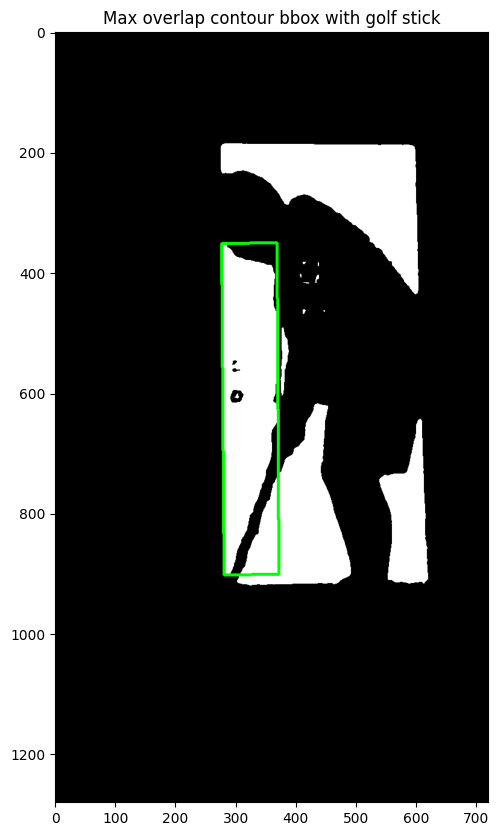

In [24]:
# draw the bounding box with max overlap
bounding_box = cv2.drawContours(cv2.cvtColor(thresh.copy(), cv2.COLOR_GRAY2BGR), [max_overlap_box], 0, (0, 255, 0), 4)  # Color set to green (BGR format)

plt.figure(figsize=(20, 10))
plt.title("Max overlap contour bbox with golf stick")
plt.imshow(bounding_box)
plt.show()


### Calculate the angle of left vertical edge with image vertical axis

In [25]:
# calculate the angle of the left vertical edge of bbox with vertical axis of image
import math 

sorted_points = max_overlap_box[np.argsort(max_overlap_box[:, 1])]
sorted_points = sorted_points[np.argsort(sorted_points[:, 0])]

# Identify the top-right and bottom-right vertices
# top-right: the point with maximum x-coordinate from the top two points
# bottom-right: the point with maximum x-coordinate from the bottom two points
top_two = sorted_points[:2]
bottom_two = sorted_points[2:]

top_right = top_two[np.argmax(top_two[:, 0])]
bottom_right = bottom_two[np.argmax(bottom_two[:, 0])]

# Calculate the differences in coordinates
dy = bottom_right[1] - top_right[1]
dx = bottom_right[0] - top_right[0]

# Calculate the angle in radians
angle_radians = math.atan2(dy, dx)

# Convert the angle to degrees
angle_degrees = math.degrees(angle_radians)

# Since we need the angle with the vertical edge (y-axis), we take 90 degrees minus the calculated angle
angle_with_vertical = 90 - angle_degrees

print(f"Angle of the right vertical edge with the right edge of the image: {angle_with_vertical:.2f} degrees")

Angle of the right vertical edge with the right edge of the image: 90.63 degrees


In [26]:
angle_degrees

-0.6295986084102668